# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


# Data Setup


## data download

In [ ]:

!unzip "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/train.zip" -d "/content/data2"


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data2/train/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /c

## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import pandas as pd
import os
import random

from PIL import Image


class CustomMultiLabelRotationDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, id_list=None):
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red', 'green', 'blue', 'yellow']


        df = pd.read_csv(csv_path)
        self.id2label = {row['Id']: row['Target'] for _, row in df.iterrows()}


        all_ids_in_csv = set(self.id2label.keys())
        all_files = os.listdir(img_dir)
        all_ids_on_disk = set(
            fname.split('_')[0] for fname in all_files if fname.endswith('_red.png')
        )
        valid_ids = sorted(all_ids_in_csv & all_ids_on_disk)


        self.available_ids = sorted(set(id_list) & set(valid_ids)) if id_list else valid_ids


        all_labels = set()
        for label_str in self.id2label.values():
            labels = map(int, label_str.split())
            all_labels.update(labels)
        self.label_map = {label: i for i, label in enumerate(sorted(all_labels))}
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.available_ids)

    def __getitem__(self, idx):
        base_id = self.available_ids[idx]
        rotation_angle = random.choice([0, 90, 180, 270])

        channels = []
        for color in self.colors:
            path = os.path.join(self.img_dir, f"{base_id}_{color}.png")
            img = Image.open(path).convert('L')
            img = img.rotate(rotation_angle)
            channels.append(img)

        image = np.stack([np.array(ch) for ch in channels], axis=0)
        image = torch.from_numpy(image).float() / 255.0

        if self.transform:
            image = self.transform(image)

        multi_hot = torch.zeros(self.num_classes)
        for label in map(int, self.id2label[base_id].split()):
            multi_hot[self.label_map[label]] = 1

        return image, multi_hot

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # transforms.ToTensor()
])

transform_val = transforms.Compose([
    # transforms.ToTensor()
])




In [ ]:
import os
import random
from sklearn.model_selection import train_test_split


img_dir = '/content/data2/train'
all_files = os.listdir(img_dir)
all_ids = sorted(set(
    fname.split('_')[0]
    for fname in all_files if fname.endswith('_red.png')
))


train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

train_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_train,
    id_list=train_ids
)

val_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_val,
    id_list=val_ids
)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

torch.Size([64, 28])


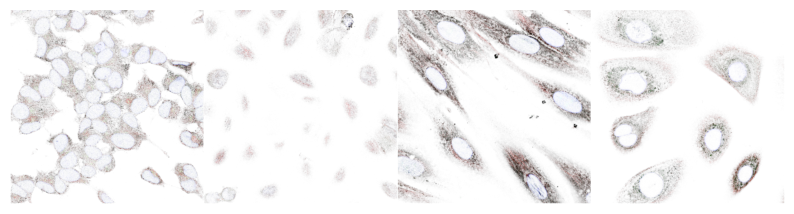

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np


for images, labels in train_loader:

    imgs = images[:4]
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    print(labels.shape)

    npimg = grid.numpy()
    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    break


In [ ]:
# from PIL import Image
# Image.open('data2/train/7adf2db4-bb9b-11e8-b2b9-ac1f6b6435d0_red.png').show()

Show some example images and rotated images with labels:

# Evaluation code

In [ ]:
import time
import torch
from sklearn.metrics import f1_score

def run_test(net, testloader, criterion, threshold=0.5):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    net.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)  # (B, C)
            probs = torch.sigmoid(outputs)  # (B, C)
            preds = (probs > threshold).float()    # threshold

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            # accuracy
            correct += (preds == labels).float().sum().item()
            total += labels.numel()  # B * C

            # loss
            avg_test_loss += criterion(outputs, labels).item()

    # batch
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    #  macro F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    avg_test_loss = avg_test_loss / len(testloader)
    acc = 100 * correct / total

    print('TESTING:')
    print(f'Accuracy (per label bit): {acc:.2f} %')
    print(f'Average loss: {avg_test_loss:.4f}')
    print(f'f1: {macro_f1:.4f}')
    return acc / 100  # for compatibility


In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.
from sklearn.metrics import f1_score
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, threshold=0.5):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, labels) in enumerate(train_loader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(outputs)  # (B, C)
            preds = (probs > threshold).float()   # threshold at 0.5

            correct = (preds == labels).float().sum()
            total = torch.numel(labels)

            running_correct += correct.item()
            running_total += total


            # macro F1
            macro_f1 = f1_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)

            if i % 100 == 99:
                acc = 100 * running_correct / running_total
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}, Acc: {acc:.2f}%, f1: {macro_f1:.2f} Time: {time.time() - start_time:.2f}s')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()


        net.eval()
        run_test(net, val_loader, criterion)

    print('✅ Finished Training')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## ResNet18

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(pretrained=True)
net.conv1 = nn.Conv2d(
    in_channels=4,
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)
net.fc = nn.Linear(in_features=512, out_features=28)
net = net.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=15, init_lr=0.001)


[Epoch 1, Batch 100] Loss: 0.000, Acc: 94.03%, f1: 0.07 Time: 68.86s
[Epoch 1, Batch 200] Loss: 0.000, Acc: 95.21%, f1: 0.20 Time: 66.85s
[Epoch 1, Batch 300] Loss: 0.000, Acc: 95.51%, f1: 0.16 Time: 67.12s
[Epoch 1, Batch 400] Loss: 0.000, Acc: 95.85%, f1: 0.21 Time: 68.21s
TESTING:
Accuracy (per label bit): 95.45 %
Average loss: 0.1293
f1: 0.1981


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 2, Batch 100] Loss: 0.000, Acc: 95.99%, f1: 0.28 Time: 69.51s
[Epoch 2, Batch 200] Loss: 0.000, Acc: 96.08%, f1: 0.25 Time: 67.78s
[Epoch 2, Batch 300] Loss: 0.000, Acc: 96.15%, f1: 0.30 Time: 68.27s
[Epoch 2, Batch 400] Loss: 0.000, Acc: 96.31%, f1: 0.25 Time: 67.73s
TESTING:
Accuracy (per label bit): 96.02 %
Average loss: 0.1113
f1: 0.2958


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 3, Batch 100] Loss: 0.000, Acc: 96.35%, f1: 0.29 Time: 68.13s
[Epoch 3, Batch 200] Loss: 0.000, Acc: 96.47%, f1: 0.31 Time: 67.23s
[Epoch 3, Batch 300] Loss: 0.000, Acc: 96.46%, f1: 0.35 Time: 66.76s
[Epoch 3, Batch 400] Loss: 0.000, Acc: 96.48%, f1: 0.36 Time: 66.77s
TESTING:
Accuracy (per label bit): 96.05 %
Average loss: 0.1118
f1: 0.3428


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 4, Batch 100] Loss: 0.000, Acc: 96.61%, f1: 0.30 Time: 67.94s
[Epoch 4, Batch 200] Loss: 0.000, Acc: 96.58%, f1: 0.35 Time: 67.10s
[Epoch 4, Batch 300] Loss: 0.000, Acc: 96.60%, f1: 0.38 Time: 67.81s
[Epoch 4, Batch 400] Loss: 0.000, Acc: 96.63%, f1: 0.30 Time: 67.51s
TESTING:
Accuracy (per label bit): 96.20 %
Average loss: 0.1095
f1: 0.3352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 5, Batch 100] Loss: 0.000, Acc: 96.74%, f1: 0.38 Time: 68.04s
[Epoch 5, Batch 200] Loss: 0.000, Acc: 96.74%, f1: 0.29 Time: 67.15s
[Epoch 5, Batch 300] Loss: 0.000, Acc: 96.80%, f1: 0.34 Time: 67.05s
[Epoch 5, Batch 400] Loss: 0.000, Acc: 96.70%, f1: 0.32 Time: 66.93s
TESTING:
Accuracy (per label bit): 96.62 %
Average loss: 0.0939
f1: 0.4337


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 6, Batch 100] Loss: 0.000, Acc: 96.78%, f1: 0.33 Time: 68.59s
[Epoch 6, Batch 200] Loss: 0.000, Acc: 96.89%, f1: 0.30 Time: 67.74s
[Epoch 6, Batch 300] Loss: 0.000, Acc: 96.83%, f1: 0.39 Time: 67.16s
[Epoch 6, Batch 400] Loss: 0.000, Acc: 96.85%, f1: 0.31 Time: 67.12s
TESTING:
Accuracy (per label bit): 96.91 %
Average loss: 0.0866
f1: 0.4433


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 7, Batch 100] Loss: 0.000, Acc: 96.91%, f1: 0.43 Time: 68.90s
[Epoch 7, Batch 200] Loss: 0.000, Acc: 96.93%, f1: 0.31 Time: 67.05s
[Epoch 7, Batch 300] Loss: 0.000, Acc: 96.86%, f1: 0.39 Time: 67.19s
[Epoch 7, Batch 400] Loss: 0.000, Acc: 96.92%, f1: 0.46 Time: 68.35s
TESTING:
Accuracy (per label bit): 96.53 %
Average loss: 0.0967
f1: 0.4574


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 8, Batch 100] Loss: 0.000, Acc: 97.03%, f1: 0.47 Time: 69.64s
[Epoch 8, Batch 200] Loss: 0.000, Acc: 96.91%, f1: 0.48 Time: 68.64s
[Epoch 8, Batch 300] Loss: 0.000, Acc: 96.95%, f1: 0.48 Time: 68.63s
[Epoch 8, Batch 400] Loss: 0.000, Acc: 96.96%, f1: 0.45 Time: 68.61s
TESTING:
Accuracy (per label bit): 96.87 %
Average loss: 0.0877
f1: 0.4431


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 9, Batch 100] Loss: 0.000, Acc: 97.06%, f1: 0.38 Time: 69.85s
[Epoch 9, Batch 200] Loss: 0.000, Acc: 97.03%, f1: 0.43 Time: 69.35s
[Epoch 9, Batch 300] Loss: 0.000, Acc: 97.07%, f1: 0.38 Time: 68.97s
[Epoch 9, Batch 400] Loss: 0.000, Acc: 97.07%, f1: 0.50 Time: 69.69s
TESTING:
Accuracy (per label bit): 96.80 %
Average loss: 0.0872
f1: 0.4515


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 10, Batch 100] Loss: 0.000, Acc: 97.08%, f1: 0.42 Time: 68.22s
[Epoch 10, Batch 200] Loss: 0.000, Acc: 97.06%, f1: 0.35 Time: 68.13s
[Epoch 10, Batch 300] Loss: 0.000, Acc: 97.07%, f1: 0.35 Time: 67.94s
[Epoch 10, Batch 400] Loss: 0.000, Acc: 97.14%, f1: 0.36 Time: 67.77s
TESTING:
Accuracy (per label bit): 96.63 %
Average loss: 0.0905
f1: 0.4541


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 11, Batch 100] Loss: 0.000, Acc: 97.14%, f1: 0.38 Time: 68.57s
[Epoch 11, Batch 200] Loss: 0.000, Acc: 97.16%, f1: 0.42 Time: 68.35s
[Epoch 11, Batch 300] Loss: 0.000, Acc: 97.17%, f1: 0.35 Time: 68.22s
[Epoch 11, Batch 400] Loss: 0.000, Acc: 97.18%, f1: 0.38 Time: 67.97s
TESTING:
Accuracy (per label bit): 96.75 %
Average loss: 0.0948
f1: 0.4458


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 12, Batch 100] Loss: 0.000, Acc: 97.23%, f1: 0.44 Time: 68.90s
[Epoch 12, Batch 200] Loss: 0.000, Acc: 97.21%, f1: 0.41 Time: 67.75s
[Epoch 12, Batch 300] Loss: 0.000, Acc: 97.22%, f1: 0.34 Time: 67.57s
[Epoch 12, Batch 400] Loss: 0.000, Acc: 97.22%, f1: 0.45 Time: 67.39s
TESTING:
Accuracy (per label bit): 96.94 %
Average loss: 0.0860
f1: 0.5106
[Epoch 13, Batch 100] Loss: 0.000, Acc: 97.24%, f1: 0.49 Time: 67.91s
[Epoch 13, Batch 200] Loss: 0.000, Acc: 97.34%, f1: 0.49 Time: 67.01s
[Epoch 13, Batch 300] Loss: 0.000, Acc: 97.27%, f1: 0.40 Time: 67.49s
[Epoch 13, Batch 400] Loss: 0.000, Acc: 97.26%, f1: 0.48 Time: 67.54s
TESTING:
Accuracy (per label bit): 97.01 %
Average loss: 0.0828
f1: 0.5094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 14, Batch 100] Loss: 0.000, Acc: 97.40%, f1: 0.43 Time: 68.38s
[Epoch 14, Batch 200] Loss: 0.000, Acc: 97.32%, f1: 0.38 Time: 67.30s
[Epoch 14, Batch 300] Loss: 0.000, Acc: 97.31%, f1: 0.44 Time: 67.20s
[Epoch 14, Batch 400] Loss: 0.000, Acc: 97.36%, f1: 0.51 Time: 67.77s
TESTING:
Accuracy (per label bit): 97.15 %
Average loss: 0.0812
f1: 0.5704


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 15, Batch 100] Loss: 0.000, Acc: 97.42%, f1: 0.44 Time: 67.42s
[Epoch 15, Batch 200] Loss: 0.000, Acc: 97.44%, f1: 0.44 Time: 66.76s
[Epoch 15, Batch 300] Loss: 0.000, Acc: 97.34%, f1: 0.43 Time: 66.95s
[Epoch 15, Batch 400] Loss: 0.000, Acc: 97.40%, f1: 0.44 Time: 66.61s
TESTING:
Accuracy (per label bit): 97.20 %
Average loss: 0.0771
f1: 0.5572


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 16, Batch 100] Loss: 0.000, Acc: 97.59%, f1: 0.50 Time: 67.69s
[Epoch 16, Batch 200] Loss: 0.000, Acc: 97.81%, f1: 0.59 Time: 66.63s
[Epoch 16, Batch 300] Loss: 0.000, Acc: 97.82%, f1: 0.48 Time: 67.02s
[Epoch 16, Batch 400] Loss: 0.000, Acc: 97.75%, f1: 0.41 Time: 67.05s
TESTING:
Accuracy (per label bit): 97.55 %
Average loss: 0.0676
f1: 0.6159


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 17, Batch 100] Loss: 0.000, Acc: 97.83%, f1: 0.57 Time: 69.00s
[Epoch 17, Batch 200] Loss: 0.000, Acc: 97.76%, f1: 0.56 Time: 68.02s
[Epoch 17, Batch 300] Loss: 0.000, Acc: 97.82%, f1: 0.55 Time: 67.62s
[Epoch 17, Batch 400] Loss: 0.000, Acc: 97.87%, f1: 0.40 Time: 67.98s
TESTING:
Accuracy (per label bit): 97.53 %
Average loss: 0.0679
f1: 0.6103


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 18, Batch 100] Loss: 0.000, Acc: 97.93%, f1: 0.47 Time: 68.04s
[Epoch 18, Batch 200] Loss: 0.000, Acc: 97.86%, f1: 0.44 Time: 66.99s
[Epoch 18, Batch 300] Loss: 0.000, Acc: 97.86%, f1: 0.53 Time: 66.92s
[Epoch 18, Batch 400] Loss: 0.000, Acc: 97.82%, f1: 0.53 Time: 67.34s
TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0674
f1: 0.6135


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 19, Batch 100] Loss: 0.000, Acc: 97.96%, f1: 0.53 Time: 68.32s
[Epoch 19, Batch 200] Loss: 0.000, Acc: 97.91%, f1: 0.52 Time: 67.89s
[Epoch 19, Batch 300] Loss: 0.000, Acc: 97.90%, f1: 0.56 Time: 68.06s
[Epoch 19, Batch 400] Loss: 0.000, Acc: 97.87%, f1: 0.50 Time: 67.17s
TESTING:
Accuracy (per label bit): 97.55 %
Average loss: 0.0680
f1: 0.6234


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 20, Batch 100] Loss: 0.000, Acc: 97.99%, f1: 0.51 Time: 68.26s
[Epoch 20, Batch 200] Loss: 0.000, Acc: 97.97%, f1: 0.57 Time: 67.22s
[Epoch 20, Batch 300] Loss: 0.000, Acc: 97.95%, f1: 0.43 Time: 67.00s
[Epoch 20, Batch 400] Loss: 0.000, Acc: 97.93%, f1: 0.61 Time: 67.27s
TESTING:
Accuracy (per label bit): 97.55 %
Average loss: 0.0670
f1: 0.6240


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 21, Batch 100] Loss: 0.000, Acc: 98.00%, f1: 0.56 Time: 67.98s
[Epoch 21, Batch 200] Loss: 0.000, Acc: 98.03%, f1: 0.53 Time: 67.41s
[Epoch 21, Batch 300] Loss: 0.000, Acc: 97.97%, f1: 0.45 Time: 67.70s
[Epoch 21, Batch 400] Loss: 0.000, Acc: 97.95%, f1: 0.43 Time: 67.65s
TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0673
f1: 0.6322


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 22, Batch 100] Loss: 0.000, Acc: 98.00%, f1: 0.48 Time: 68.38s
[Epoch 22, Batch 200] Loss: 0.000, Acc: 97.99%, f1: 0.55 Time: 67.69s
[Epoch 22, Batch 300] Loss: 0.000, Acc: 97.98%, f1: 0.49 Time: 68.03s
[Epoch 22, Batch 400] Loss: 0.000, Acc: 98.07%, f1: 0.58 Time: 66.67s
TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0674
f1: 0.6276


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 23, Batch 100] Loss: 0.000, Acc: 98.07%, f1: 0.39 Time: 67.67s
[Epoch 23, Batch 200] Loss: 0.000, Acc: 98.04%, f1: 0.49 Time: 66.86s
[Epoch 23, Batch 300] Loss: 0.000, Acc: 98.03%, f1: 0.58 Time: 67.55s
[Epoch 23, Batch 400] Loss: 0.000, Acc: 98.01%, f1: 0.59 Time: 67.28s
TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0672
f1: 0.6218


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 24, Batch 100] Loss: 0.000, Acc: 98.09%, f1: 0.49 Time: 68.80s
[Epoch 24, Batch 200] Loss: 0.000, Acc: 98.06%, f1: 0.55 Time: 67.66s
[Epoch 24, Batch 300] Loss: 0.000, Acc: 98.11%, f1: 0.37 Time: 67.52s
[Epoch 24, Batch 400] Loss: 0.000, Acc: 98.02%, f1: 0.63 Time: 68.13s
TESTING:
Accuracy (per label bit): 97.59 %
Average loss: 0.0673
f1: 0.6244


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 25, Batch 100] Loss: 0.000, Acc: 98.13%, f1: 0.44 Time: 68.46s
[Epoch 25, Batch 200] Loss: 0.000, Acc: 98.12%, f1: 0.48 Time: 67.44s
[Epoch 25, Batch 300] Loss: 0.000, Acc: 98.07%, f1: 0.58 Time: 67.24s
[Epoch 25, Batch 400] Loss: 0.000, Acc: 98.15%, f1: 0.53 Time: 66.93s
TESTING:
Accuracy (per label bit): 97.50 %
Average loss: 0.0696
f1: 0.6313


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 26, Batch 100] Loss: 0.000, Acc: 98.18%, f1: 0.49 Time: 68.17s
[Epoch 26, Batch 200] Loss: 0.000, Acc: 98.10%, f1: 0.46 Time: 67.35s
[Epoch 26, Batch 300] Loss: 0.000, Acc: 98.18%, f1: 0.62 Time: 68.40s
[Epoch 26, Batch 400] Loss: 0.000, Acc: 98.11%, f1: 0.53 Time: 68.08s
TESTING:
Accuracy (per label bit): 97.59 %
Average loss: 0.0676
f1: 0.6253


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 27, Batch 100] Loss: 0.000, Acc: 98.18%, f1: 0.58 Time: 68.81s
[Epoch 27, Batch 200] Loss: 0.000, Acc: 98.19%, f1: 0.48 Time: 68.34s
[Epoch 27, Batch 300] Loss: 0.000, Acc: 98.17%, f1: 0.66 Time: 67.08s
[Epoch 27, Batch 400] Loss: 0.000, Acc: 98.17%, f1: 0.53 Time: 66.18s
TESTING:
Accuracy (per label bit): 97.60 %
Average loss: 0.0682
f1: 0.6482


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 28, Batch 100] Loss: 0.000, Acc: 98.21%, f1: 0.44 Time: 67.09s
[Epoch 28, Batch 200] Loss: 0.000, Acc: 98.20%, f1: 0.52 Time: 67.24s
[Epoch 28, Batch 300] Loss: 0.000, Acc: 98.19%, f1: 0.45 Time: 66.69s
[Epoch 28, Batch 400] Loss: 0.000, Acc: 98.22%, f1: 0.60 Time: 66.33s
TESTING:
Accuracy (per label bit): 97.55 %
Average loss: 0.0690
f1: 0.6296


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 29, Batch 100] Loss: 0.000, Acc: 98.26%, f1: 0.56 Time: 67.30s
[Epoch 29, Batch 200] Loss: 0.000, Acc: 98.27%, f1: 0.66 Time: 66.99s
[Epoch 29, Batch 300] Loss: 0.000, Acc: 98.24%, f1: 0.50 Time: 66.72s
[Epoch 29, Batch 400] Loss: 0.000, Acc: 98.23%, f1: 0.45 Time: 66.48s
TESTING:
Accuracy (per label bit): 97.50 %
Average loss: 0.0704
f1: 0.6178


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 30, Batch 100] Loss: 0.000, Acc: 98.29%, f1: 0.50 Time: 67.52s
[Epoch 30, Batch 200] Loss: 0.000, Acc: 98.26%, f1: 0.51 Time: 66.08s
[Epoch 30, Batch 300] Loss: 0.000, Acc: 98.22%, f1: 0.52 Time: 66.64s
[Epoch 30, Batch 400] Loss: 0.000, Acc: 98.23%, f1: 0.55 Time: 66.18s
TESTING:
Accuracy (per label bit): 97.60 %
Average loss: 0.0681
f1: 0.6396
✅ Finished Training


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.save(net, 'model_resnet18.pth')

## Resnet 34

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet34

net = resnet34(pretrained=True)
net.conv1 = nn.Conv2d(
    in_channels=4,
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)
net.fc = nn.Linear(in_features=512, out_features=28)
net = net.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]


In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=15, init_lr=0.001)


[Epoch 1, Batch 100] Loss: 0.000, Acc: 94.09%, f1: 0.06 Time: 69.96s
[Epoch 1, Batch 200] Loss: 0.000, Acc: 95.15%, f1: 0.09 Time: 69.85s
[Epoch 1, Batch 300] Loss: 0.000, Acc: 95.33%, f1: 0.13 Time: 66.61s
[Epoch 1, Batch 400] Loss: 0.000, Acc: 95.63%, f1: 0.20 Time: 67.54s
TESTING:
Accuracy (per label bit): 95.75 %
Average loss: 0.1284
f1: 0.2363


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 2, Batch 100] Loss: 0.000, Acc: 95.79%, f1: 0.25 Time: 71.91s
[Epoch 2, Batch 200] Loss: 0.000, Acc: 95.90%, f1: 0.23 Time: 71.30s
[Epoch 2, Batch 300] Loss: 0.000, Acc: 96.05%, f1: 0.26 Time: 71.26s
[Epoch 2, Batch 400] Loss: 0.000, Acc: 96.15%, f1: 0.32 Time: 70.46s
TESTING:
Accuracy (per label bit): 96.16 %
Average loss: 0.1130
f1: 0.2914


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 3, Batch 100] Loss: 0.000, Acc: 96.22%, f1: 0.28 Time: 70.81s
[Epoch 3, Batch 200] Loss: 0.000, Acc: 96.33%, f1: 0.30 Time: 69.68s
[Epoch 3, Batch 300] Loss: 0.000, Acc: 96.38%, f1: 0.32 Time: 70.11s
[Epoch 3, Batch 400] Loss: 0.000, Acc: 96.40%, f1: 0.26 Time: 69.42s
TESTING:
Accuracy (per label bit): 96.27 %
Average loss: 0.1068
f1: 0.3489


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 4, Batch 100] Loss: 0.000, Acc: 96.59%, f1: 0.36 Time: 67.27s
[Epoch 4, Batch 200] Loss: 0.000, Acc: 96.43%, f1: 0.34 Time: 66.41s
[Epoch 4, Batch 300] Loss: 0.000, Acc: 96.56%, f1: 0.30 Time: 66.34s
[Epoch 4, Batch 400] Loss: 0.000, Acc: 96.55%, f1: 0.29 Time: 65.85s
TESTING:
Accuracy (per label bit): 96.54 %
Average loss: 0.0987
f1: 0.3780


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 5, Batch 100] Loss: 0.000, Acc: 96.65%, f1: 0.33 Time: 70.78s
[Epoch 5, Batch 200] Loss: 0.000, Acc: 96.72%, f1: 0.30 Time: 70.47s
[Epoch 5, Batch 300] Loss: 0.000, Acc: 96.68%, f1: 0.31 Time: 71.10s
[Epoch 5, Batch 400] Loss: 0.000, Acc: 96.65%, f1: 0.34 Time: 68.05s
TESTING:
Accuracy (per label bit): 96.58 %
Average loss: 0.0945
f1: 0.4132


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 6, Batch 100] Loss: 0.000, Acc: 96.71%, f1: 0.43 Time: 68.58s
[Epoch 6, Batch 200] Loss: 0.000, Acc: 96.79%, f1: 0.35 Time: 71.23s
[Epoch 6, Batch 300] Loss: 0.000, Acc: 96.83%, f1: 0.35 Time: 70.65s
[Epoch 6, Batch 400] Loss: 0.000, Acc: 96.87%, f1: 0.39 Time: 69.10s
TESTING:
Accuracy (per label bit): 96.52 %
Average loss: 0.0988
f1: 0.4108


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 7, Batch 100] Loss: 0.000, Acc: 96.87%, f1: 0.34 Time: 69.61s
[Epoch 7, Batch 200] Loss: 0.000, Acc: 96.89%, f1: 0.37 Time: 69.20s
[Epoch 7, Batch 300] Loss: 0.000, Acc: 96.88%, f1: 0.41 Time: 69.36s
[Epoch 7, Batch 400] Loss: 0.000, Acc: 96.92%, f1: 0.42 Time: 69.47s
TESTING:
Accuracy (per label bit): 96.92 %
Average loss: 0.0870
f1: 0.4846


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 8, Batch 100] Loss: 0.000, Acc: 96.91%, f1: 0.36 Time: 67.37s
[Epoch 8, Batch 200] Loss: 0.000, Acc: 96.93%, f1: 0.41 Time: 66.39s
[Epoch 8, Batch 300] Loss: 0.000, Acc: 96.93%, f1: 0.45 Time: 66.93s
[Epoch 8, Batch 400] Loss: 0.000, Acc: 96.95%, f1: 0.38 Time: 66.69s
TESTING:
Accuracy (per label bit): 96.51 %
Average loss: 0.0980
f1: 0.4001


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 9, Batch 100] Loss: 0.000, Acc: 97.02%, f1: 0.44 Time: 69.91s
[Epoch 9, Batch 200] Loss: 0.000, Acc: 97.00%, f1: 0.37 Time: 69.52s
[Epoch 9, Batch 300] Loss: 0.000, Acc: 97.07%, f1: 0.41 Time: 69.33s
[Epoch 9, Batch 400] Loss: 0.000, Acc: 96.96%, f1: 0.33 Time: 69.24s
TESTING:
Accuracy (per label bit): 97.00 %
Average loss: 0.0830
f1: 0.4676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 10, Batch 100] Loss: 0.000, Acc: 97.08%, f1: 0.38 Time: 69.36s
[Epoch 10, Batch 200] Loss: 0.000, Acc: 97.04%, f1: 0.41 Time: 67.22s
[Epoch 10, Batch 300] Loss: 0.000, Acc: 97.06%, f1: 0.35 Time: 67.77s
[Epoch 10, Batch 400] Loss: 0.000, Acc: 97.12%, f1: 0.45 Time: 67.30s
TESTING:
Accuracy (per label bit): 96.70 %
Average loss: 0.0920
f1: 0.4870


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 11, Batch 100] Loss: 0.000, Acc: 97.16%, f1: 0.32 Time: 69.13s
[Epoch 11, Batch 200] Loss: 0.000, Acc: 97.06%, f1: 0.30 Time: 67.86s
[Epoch 11, Batch 300] Loss: 0.000, Acc: 97.16%, f1: 0.41 Time: 69.39s
[Epoch 11, Batch 400] Loss: 0.000, Acc: 97.18%, f1: 0.40 Time: 67.75s
TESTING:
Accuracy (per label bit): 97.07 %
Average loss: 0.0830
f1: 0.4692


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 12, Batch 100] Loss: 0.000, Acc: 97.28%, f1: 0.45 Time: 72.85s
[Epoch 12, Batch 200] Loss: 0.000, Acc: 97.18%, f1: 0.43 Time: 70.10s
[Epoch 12, Batch 300] Loss: 0.000, Acc: 97.26%, f1: 0.38 Time: 71.17s
[Epoch 12, Batch 400] Loss: 0.000, Acc: 97.12%, f1: 0.39 Time: 71.36s
TESTING:
Accuracy (per label bit): 96.85 %
Average loss: 0.0868
f1: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 13, Batch 100] Loss: 0.000, Acc: 97.23%, f1: 0.47 Time: 70.34s
[Epoch 13, Batch 200] Loss: 0.000, Acc: 97.27%, f1: 0.34 Time: 69.96s
[Epoch 13, Batch 300] Loss: 0.000, Acc: 97.22%, f1: 0.38 Time: 68.11s
[Epoch 13, Batch 400] Loss: 0.000, Acc: 97.24%, f1: 0.38 Time: 68.07s
TESTING:
Accuracy (per label bit): 97.15 %
Average loss: 0.0803
f1: 0.5444


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 14, Batch 100] Loss: 0.000, Acc: 97.33%, f1: 0.39 Time: 70.89s
[Epoch 14, Batch 200] Loss: 0.000, Acc: 97.31%, f1: 0.50 Time: 70.30s
[Epoch 14, Batch 300] Loss: 0.000, Acc: 97.18%, f1: 0.46 Time: 70.09s
[Epoch 14, Batch 400] Loss: 0.000, Acc: 97.37%, f1: 0.46 Time: 71.04s
TESTING:
Accuracy (per label bit): 96.85 %
Average loss: 0.0867
f1: 0.4882


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 15, Batch 100] Loss: 0.000, Acc: 97.37%, f1: 0.44 Time: 73.29s
[Epoch 15, Batch 200] Loss: 0.000, Acc: 97.33%, f1: 0.45 Time: 71.10s
[Epoch 15, Batch 300] Loss: 0.000, Acc: 97.32%, f1: 0.35 Time: 71.59s
[Epoch 15, Batch 400] Loss: 0.000, Acc: 97.32%, f1: 0.40 Time: 71.66s
TESTING:
Accuracy (per label bit): 96.99 %
Average loss: 0.0812
f1: 0.5641


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 16, Batch 100] Loss: 0.000, Acc: 97.63%, f1: 0.46 Time: 71.33s
[Epoch 16, Batch 200] Loss: 0.000, Acc: 97.62%, f1: 0.48 Time: 70.22s
[Epoch 16, Batch 300] Loss: 0.000, Acc: 97.67%, f1: 0.44 Time: 71.50s
[Epoch 16, Batch 400] Loss: 0.000, Acc: 97.79%, f1: 0.56 Time: 71.92s
TESTING:
Accuracy (per label bit): 97.50 %
Average loss: 0.0691
f1: 0.5979


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 17, Batch 100] Loss: 0.000, Acc: 97.76%, f1: 0.54 Time: 68.39s
[Epoch 17, Batch 200] Loss: 0.000, Acc: 97.77%, f1: 0.60 Time: 66.92s
[Epoch 17, Batch 300] Loss: 0.000, Acc: 97.76%, f1: 0.41 Time: 66.91s
[Epoch 17, Batch 400] Loss: 0.000, Acc: 97.81%, f1: 0.47 Time: 67.82s
TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0675
f1: 0.6272


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 18, Batch 100] Loss: 0.000, Acc: 97.85%, f1: 0.52 Time: 68.41s
[Epoch 18, Batch 200] Loss: 0.000, Acc: 97.87%, f1: 0.49 Time: 68.19s
[Epoch 18, Batch 300] Loss: 0.000, Acc: 97.81%, f1: 0.45 Time: 68.12s
[Epoch 18, Batch 400] Loss: 0.000, Acc: 97.85%, f1: 0.49 Time: 68.19s
TESTING:
Accuracy (per label bit): 97.53 %
Average loss: 0.0678
f1: 0.6334


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 19, Batch 100] Loss: 0.000, Acc: 97.83%, f1: 0.44 Time: 67.14s
[Epoch 19, Batch 200] Loss: 0.000, Acc: 97.93%, f1: 0.44 Time: 66.36s
[Epoch 19, Batch 300] Loss: 0.000, Acc: 97.95%, f1: 0.56 Time: 66.86s
[Epoch 19, Batch 400] Loss: 0.000, Acc: 97.87%, f1: 0.49 Time: 66.73s
TESTING:
Accuracy (per label bit): 97.54 %
Average loss: 0.0677
f1: 0.6125


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 20, Batch 100] Loss: 0.000, Acc: 97.94%, f1: 0.53 Time: 67.20s
[Epoch 20, Batch 200] Loss: 0.000, Acc: 97.94%, f1: 0.46 Time: 67.20s
[Epoch 20, Batch 300] Loss: 0.000, Acc: 97.88%, f1: 0.54 Time: 66.90s
[Epoch 20, Batch 400] Loss: 0.000, Acc: 97.93%, f1: 0.56 Time: 66.49s
TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0673
f1: 0.6217


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 21, Batch 100] Loss: 0.000, Acc: 97.90%, f1: 0.41 Time: 68.64s
[Epoch 21, Batch 200] Loss: 0.000, Acc: 97.93%, f1: 0.51 Time: 68.17s
[Epoch 21, Batch 300] Loss: 0.000, Acc: 97.98%, f1: 0.55 Time: 67.89s
[Epoch 21, Batch 400] Loss: 0.000, Acc: 98.00%, f1: 0.57 Time: 67.59s
TESTING:
Accuracy (per label bit): 97.56 %
Average loss: 0.0680
f1: 0.6258


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 22, Batch 100] Loss: 0.000, Acc: 98.02%, f1: 0.58 Time: 71.66s
[Epoch 22, Batch 200] Loss: 0.000, Acc: 97.96%, f1: 0.40 Time: 70.90s
[Epoch 22, Batch 300] Loss: 0.000, Acc: 97.96%, f1: 0.63 Time: 70.76s
[Epoch 22, Batch 400] Loss: 0.000, Acc: 97.96%, f1: 0.44 Time: 71.25s
TESTING:
Accuracy (per label bit): 97.57 %
Average loss: 0.0680
f1: 0.6197


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 23, Batch 100] Loss: 0.000, Acc: 98.01%, f1: 0.59 Time: 67.79s


In [ ]:
torch.save(net, 'model_resnet34.pth')